# Telecom Customer Churn

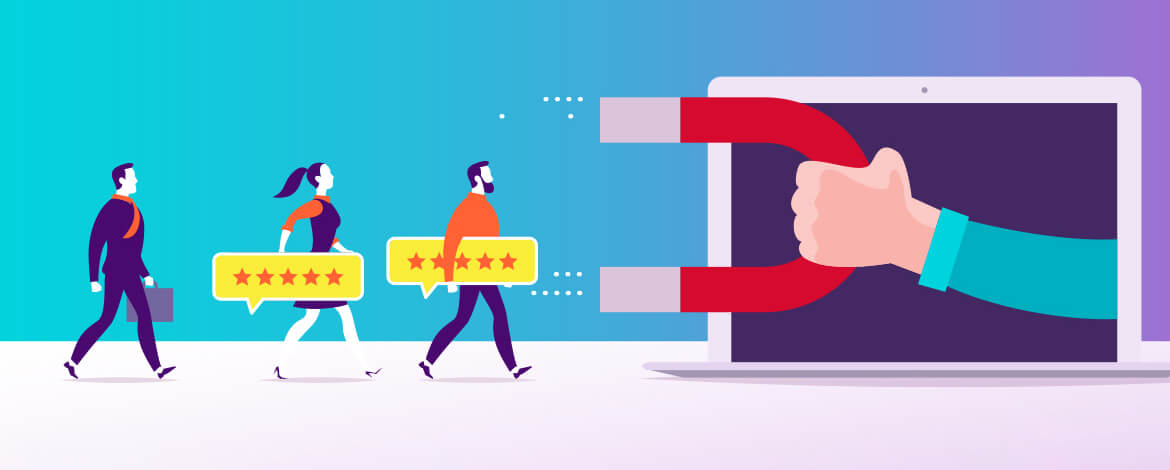

# Objectives:
### I will explore the data and try to answer some questions like:

* What's the % of Churn Customers and customers that keep in with the active services.

* We have difference pattern of churn between genders ?
* What's the difference between customers that pay monthly and by year?
* what's the most profitable service types?
* A lot of other questions that will raise trought the exploration


# Load neccesary libraries and data

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.ticker as mtick # For specifying the axes tick format 

from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix,precision_score, recall_score,f1_score

In [43]:
telecom_cust = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [44]:
# convert total sum to numeric feature
telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')
telecom_cust.dropna(inplace = True)


In [45]:
telecom_cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Understanding the data

### let's first look at the churn rate in our data

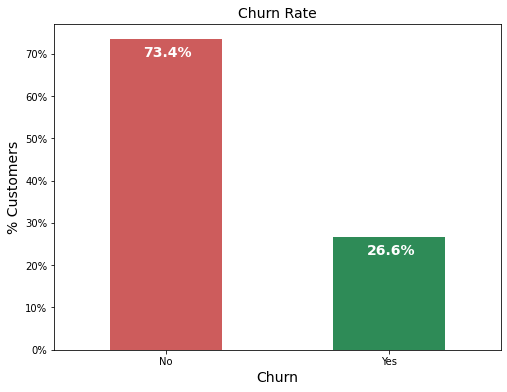

In [46]:
draw_hist(telecom_cust,'Churn')



 <font size="3"> Clearly the data is skewed . We will keep this in mind in the modeling section as this will cause a lot of false negatives</font>




### Plotting all categorical features:
 <font size="3"> I will plot all categorical features distributions with the % of Churn by each category</font>


In [47]:
telecom_cust_categorical = telecom_cust.drop(['customerID','tenure','MonthlyCharges', 'TotalCharges'], axis=1)
cols = list(telecom_cust_categorical.columns)

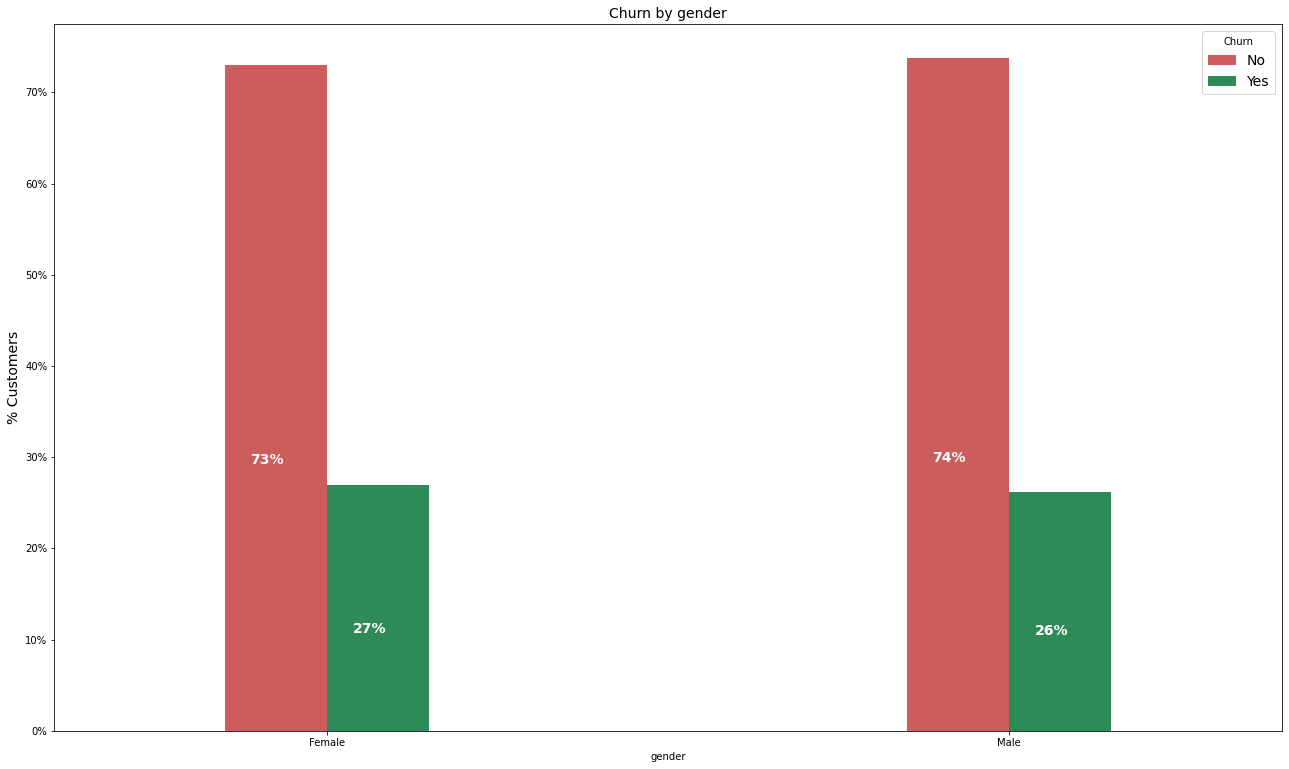

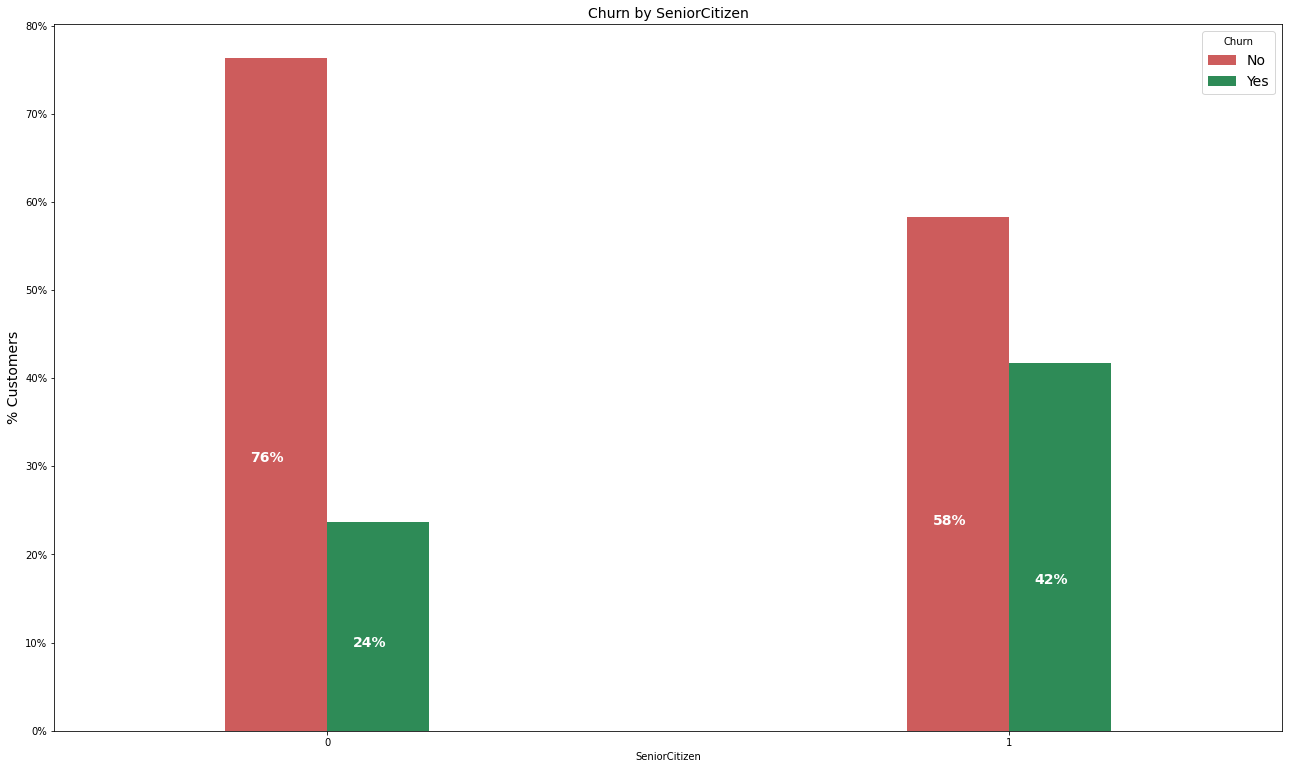

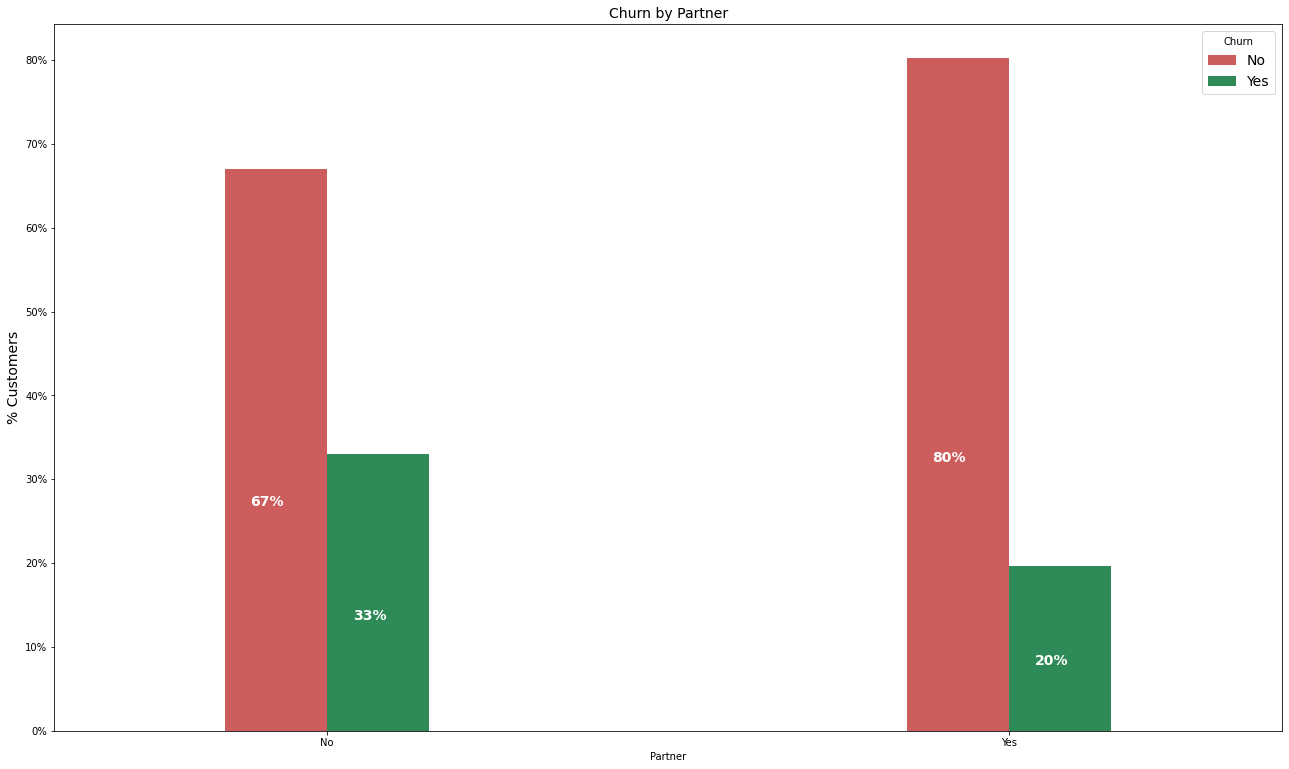

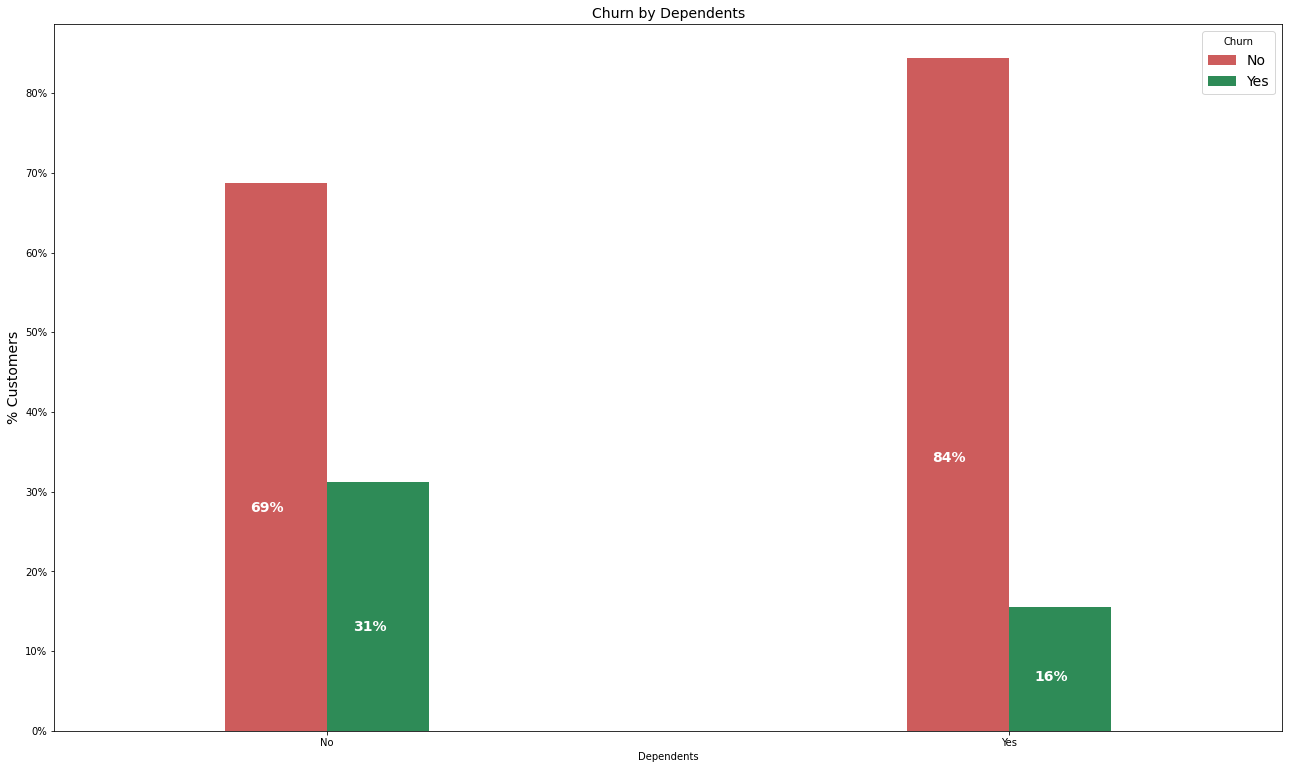

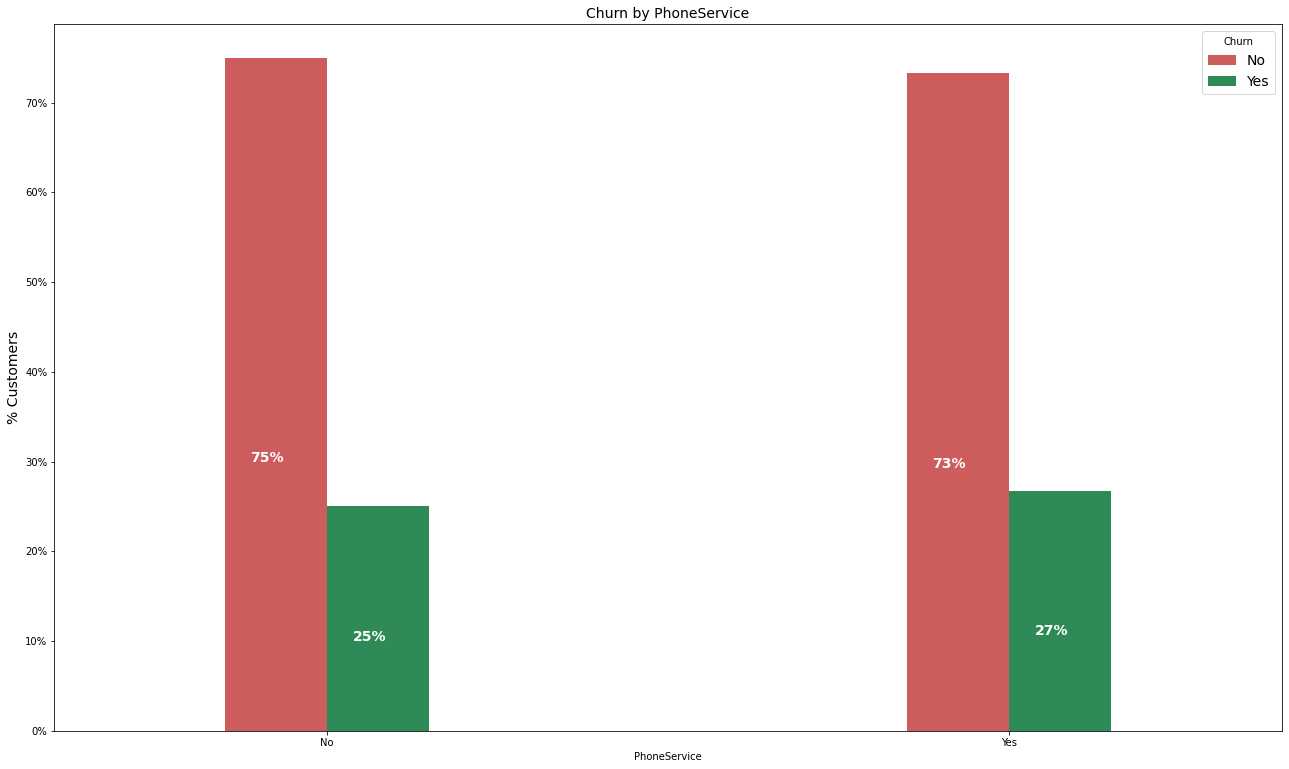

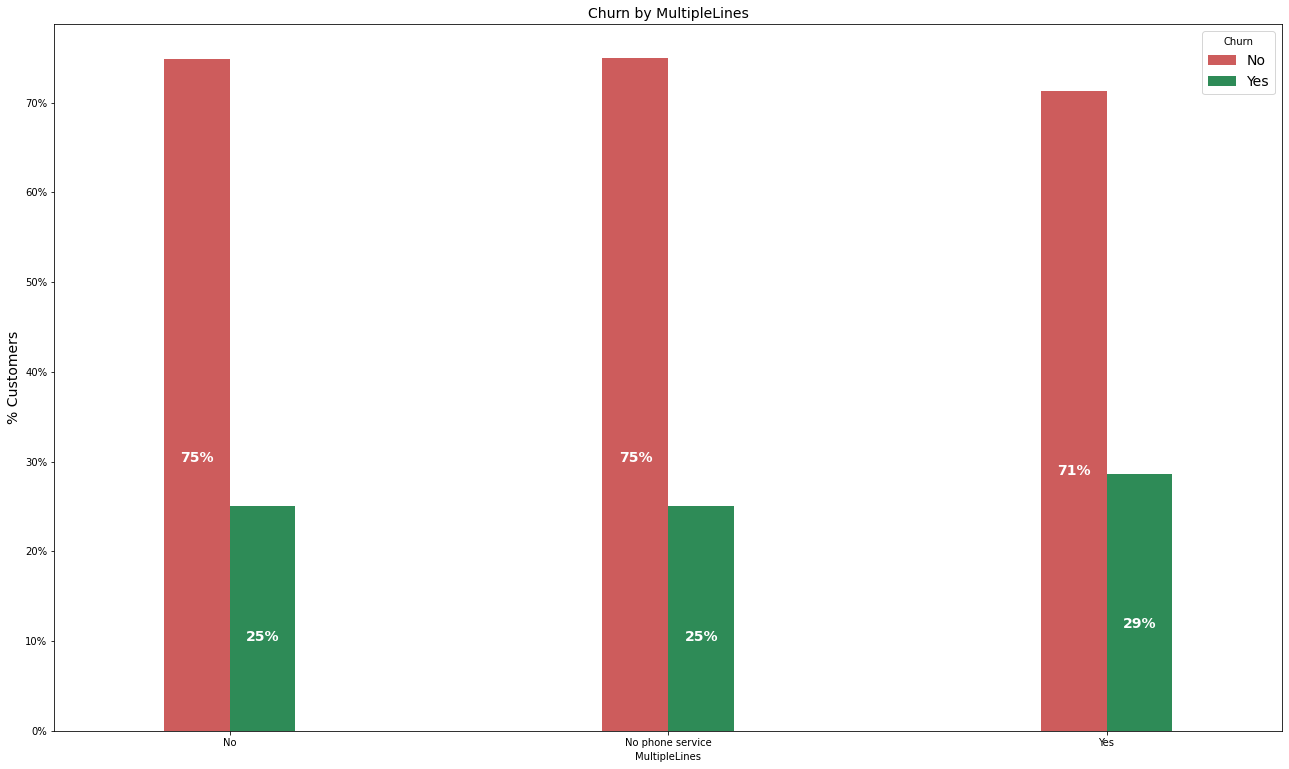

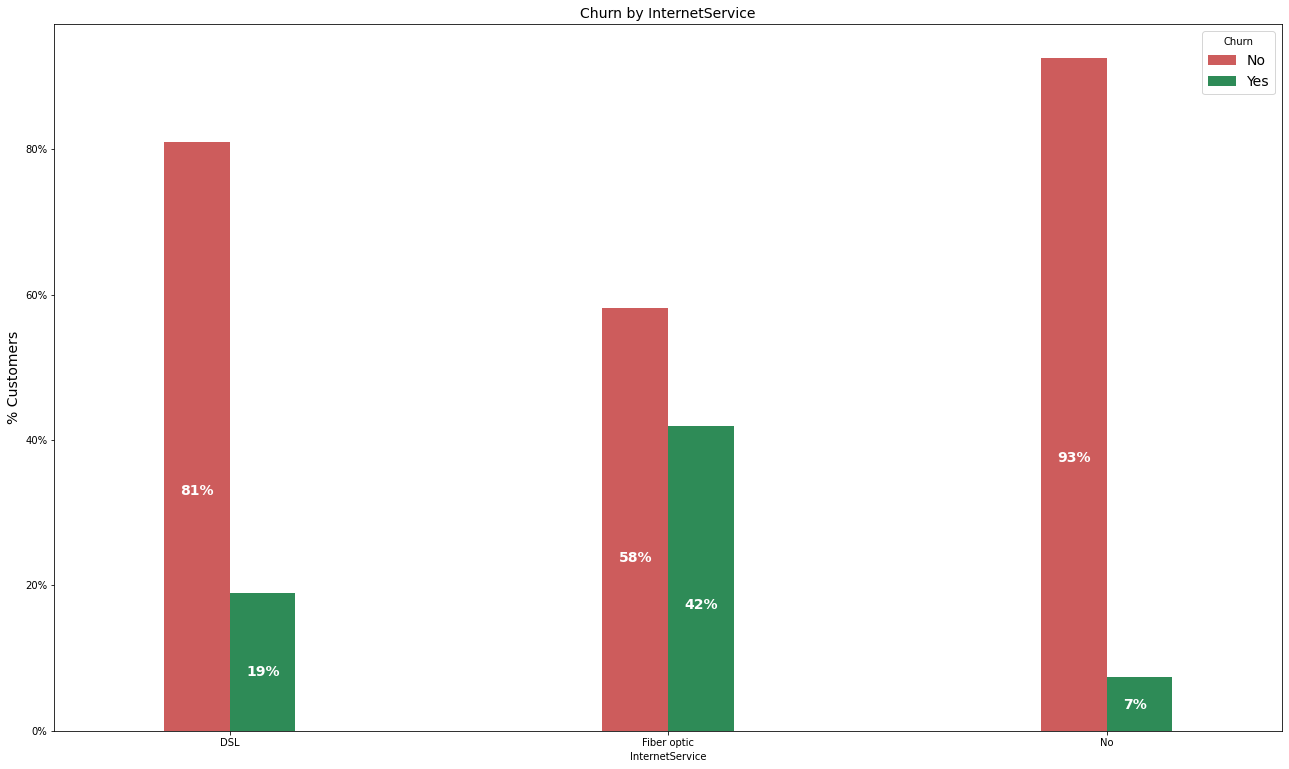

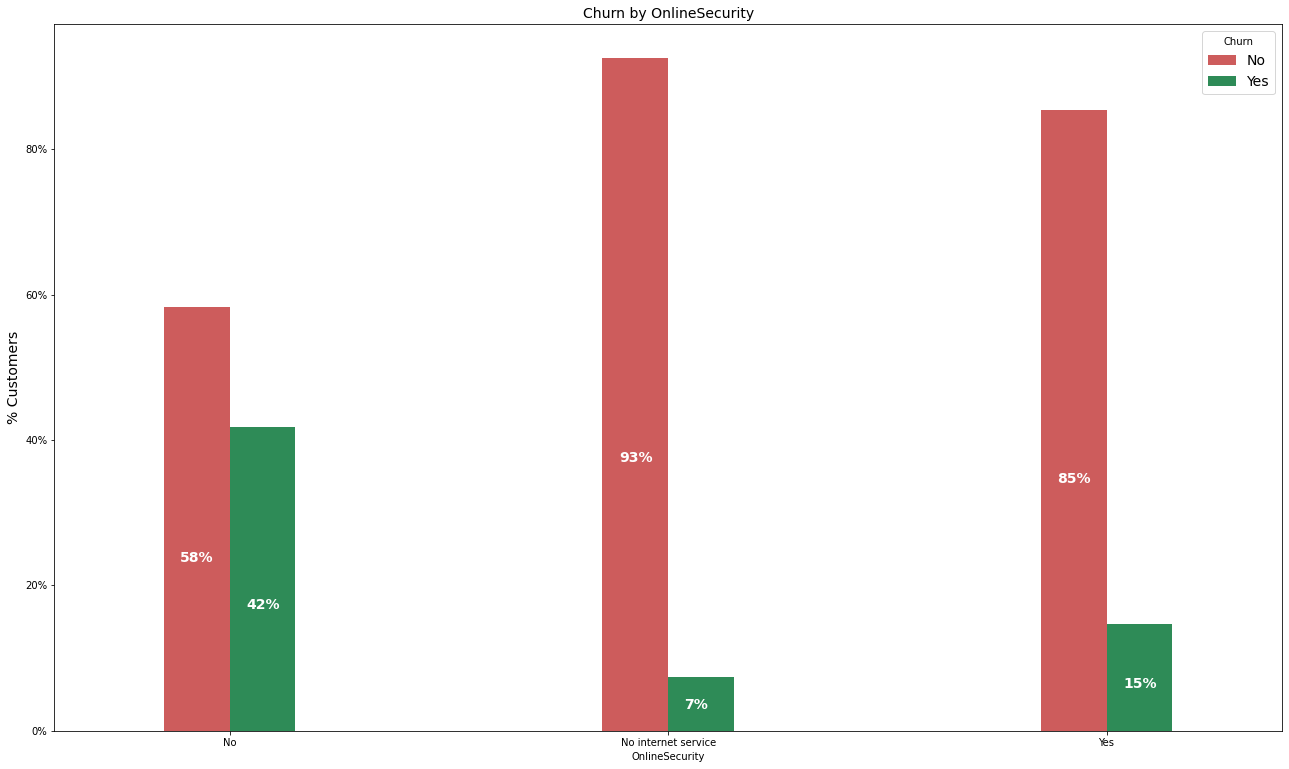

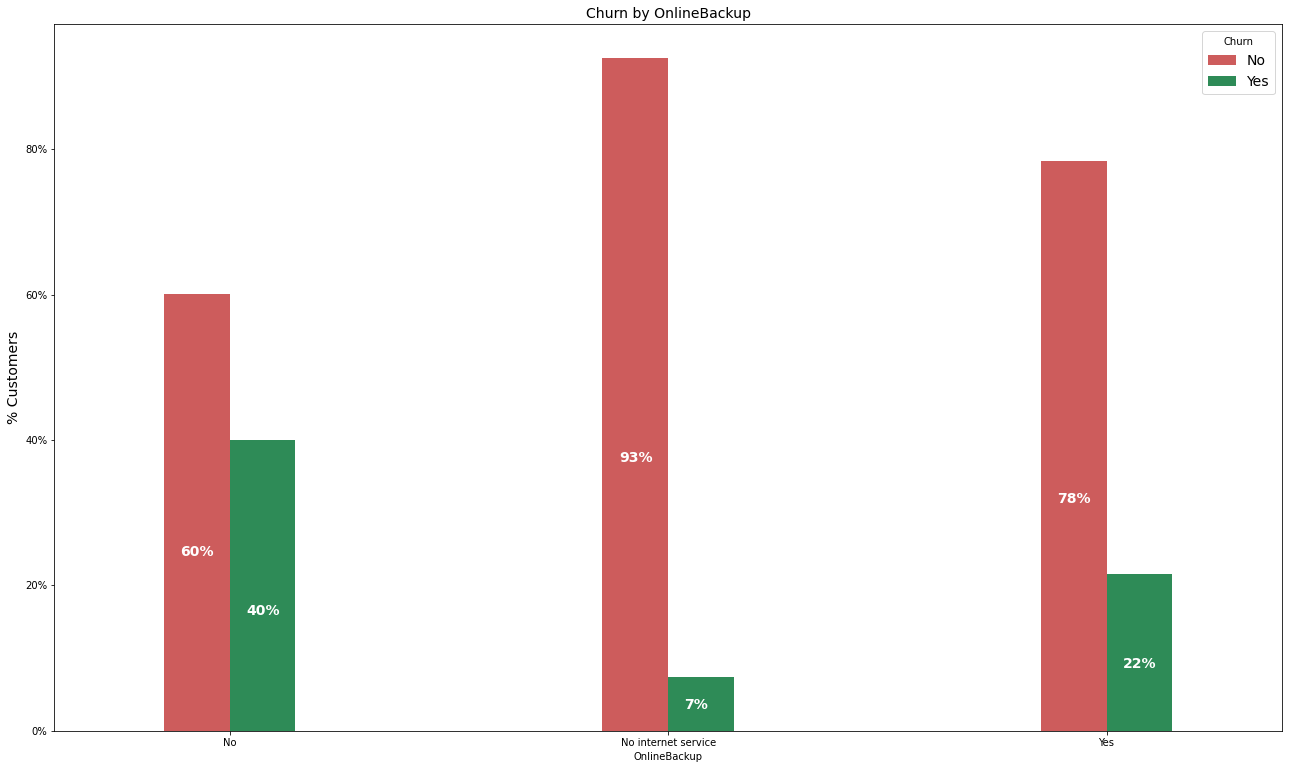

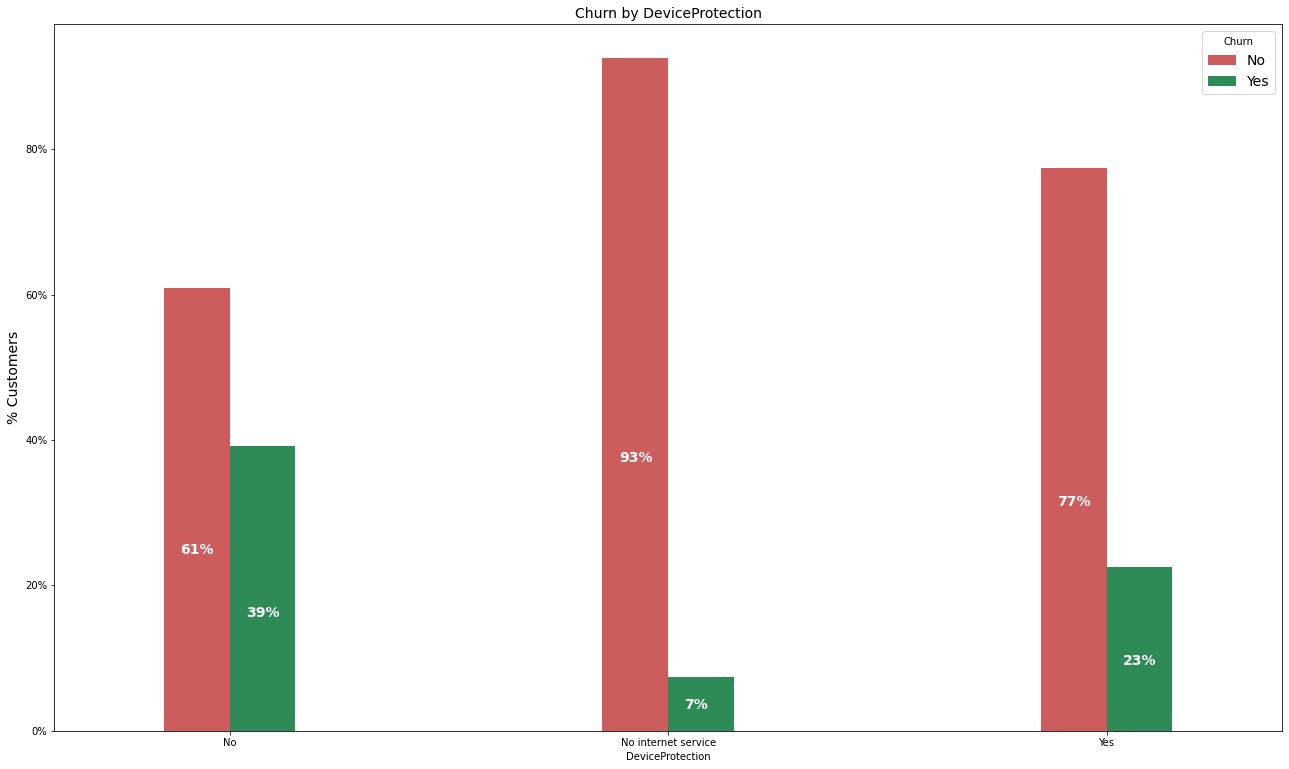

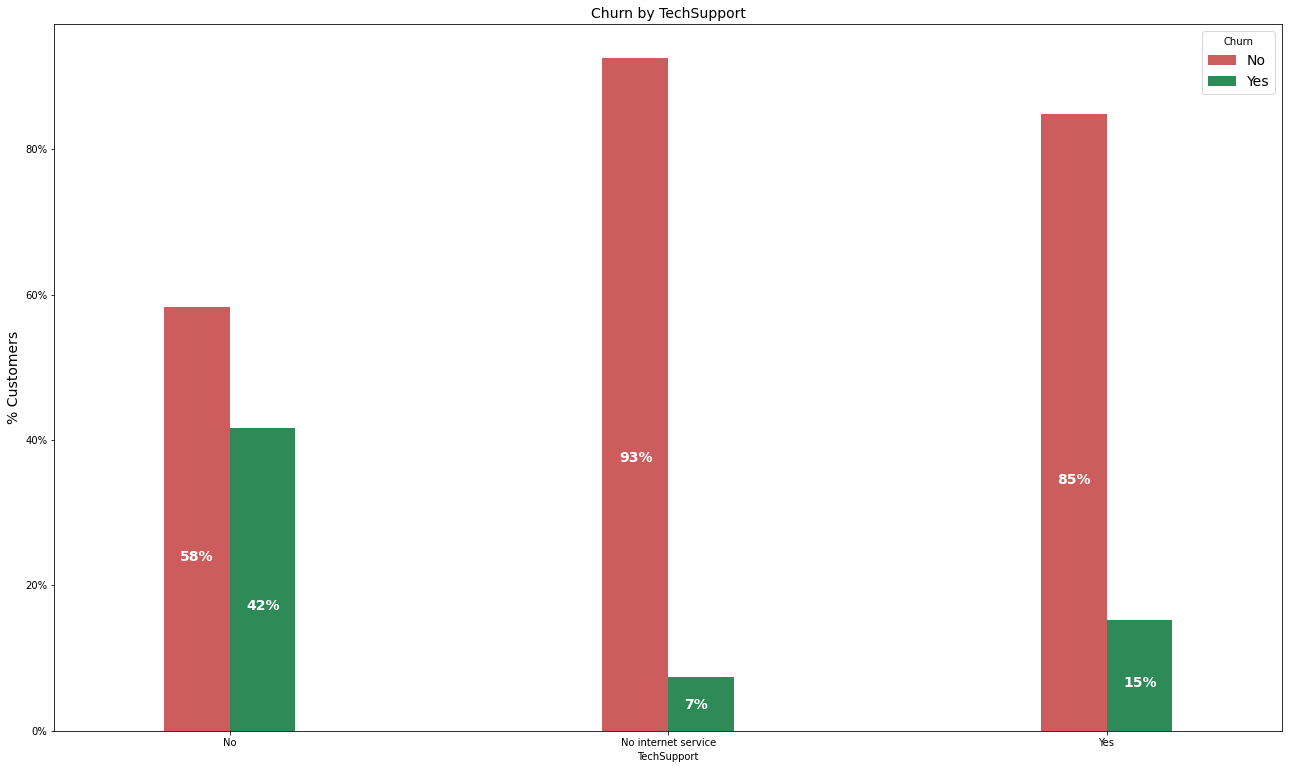

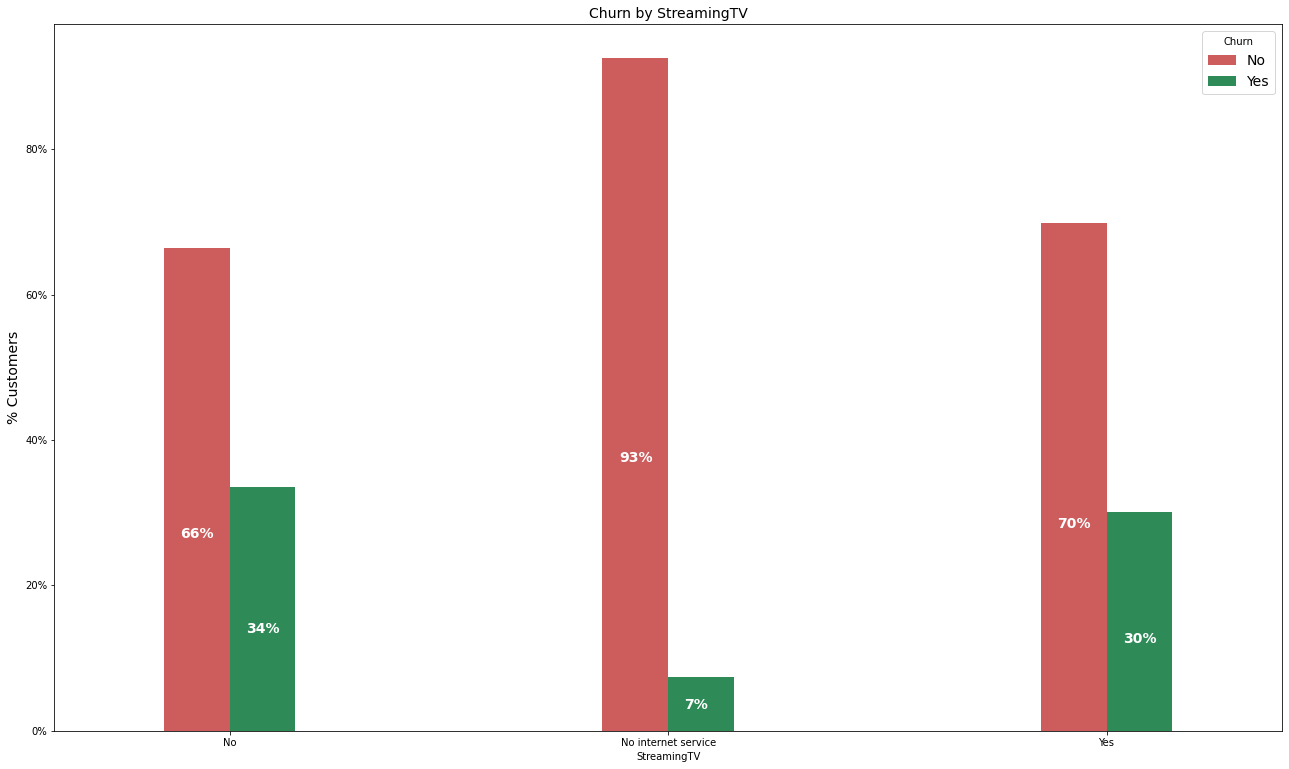

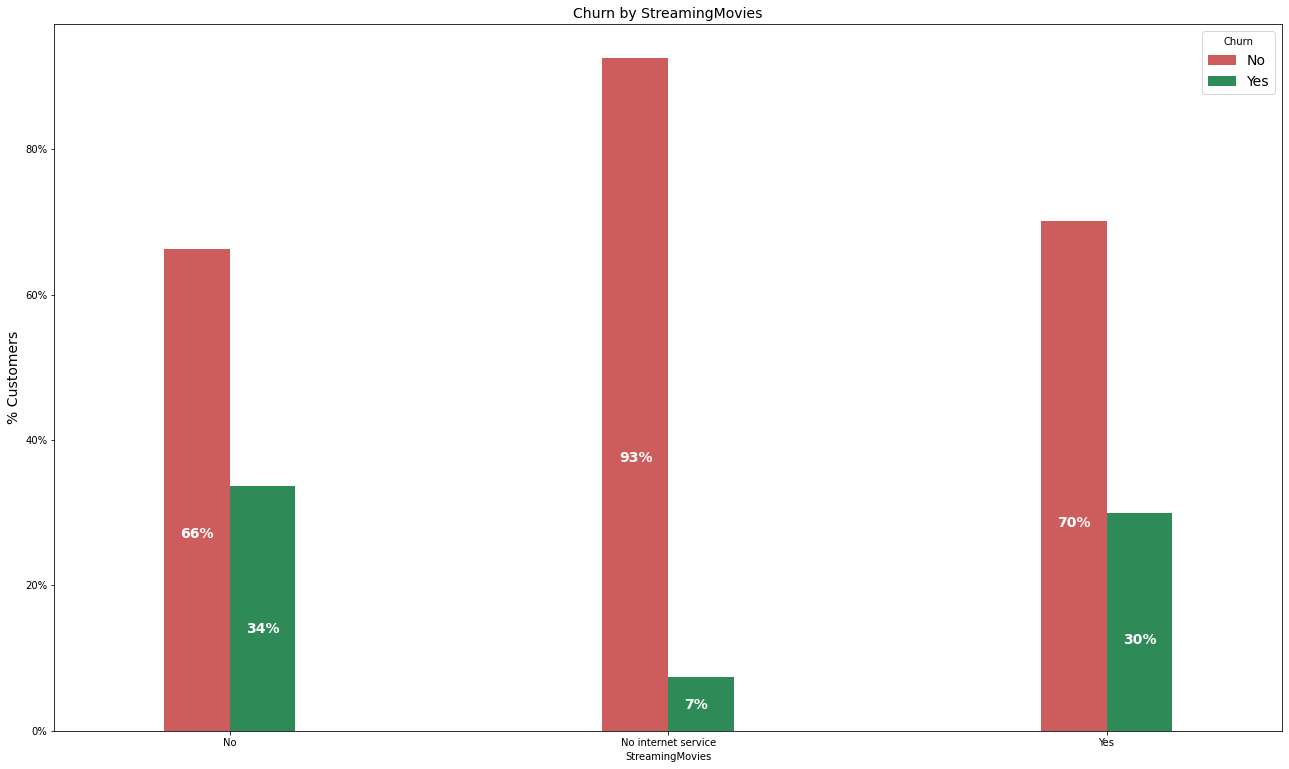

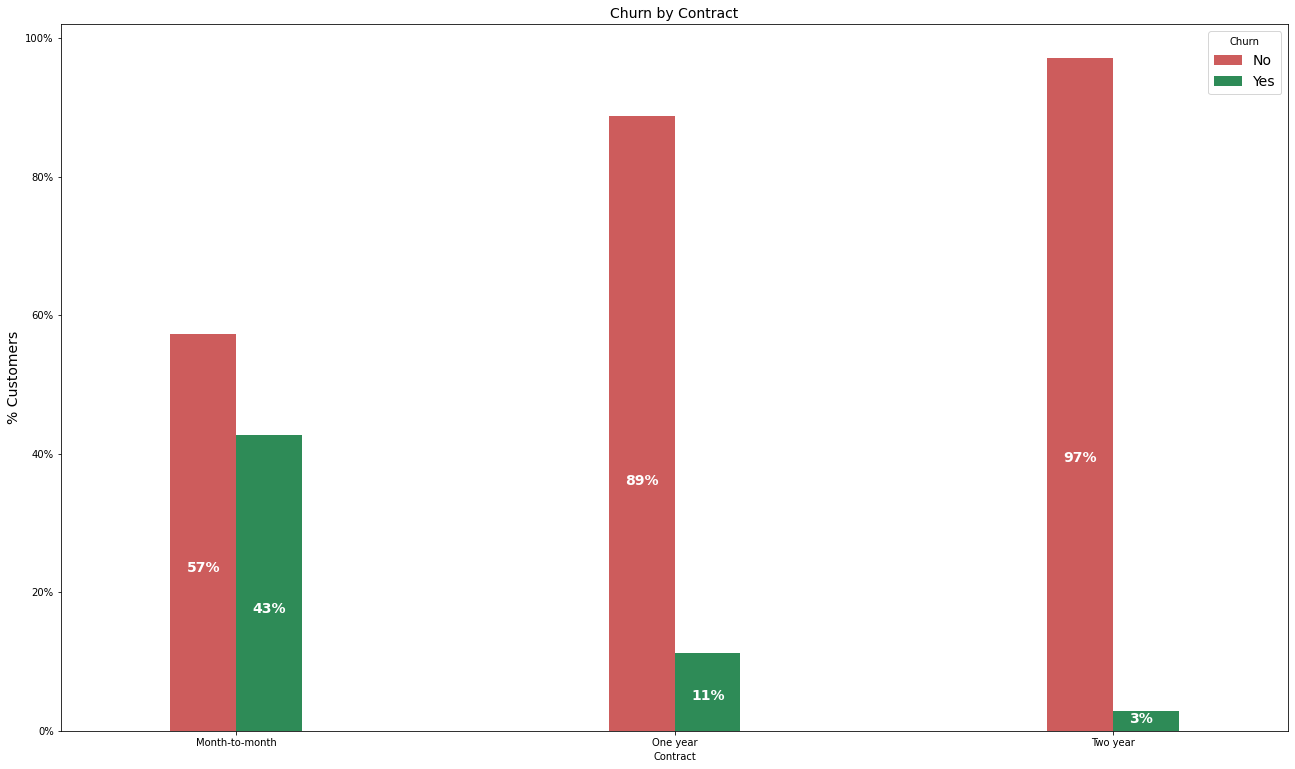

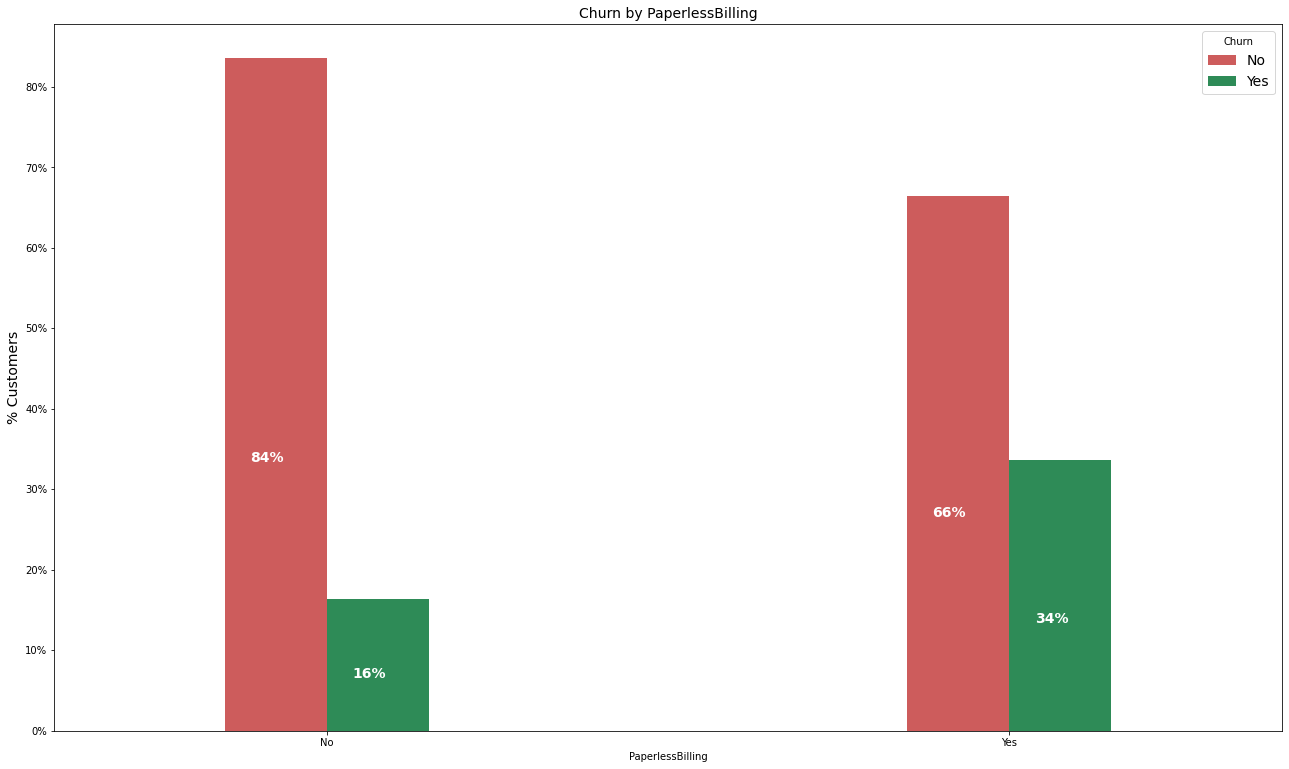

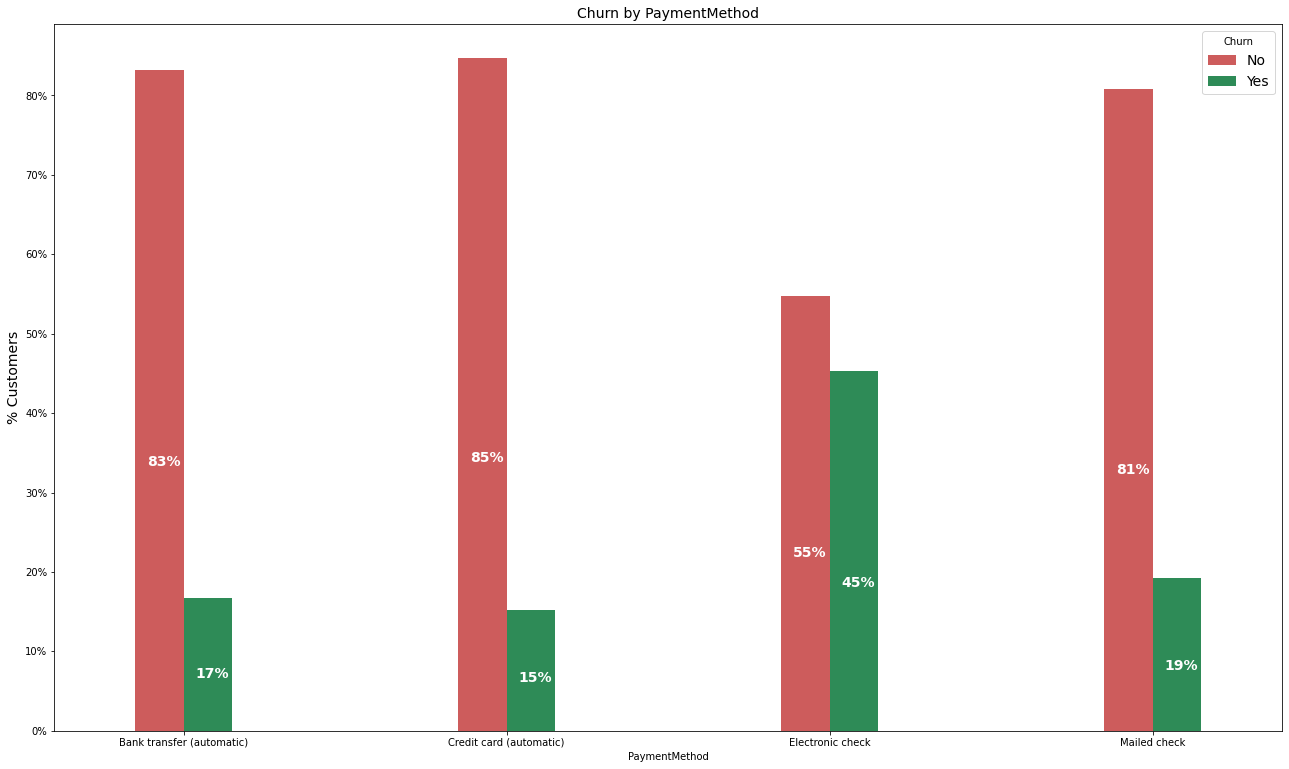

In [48]:
for i in range(len(cols) - 1):
    bar_with_churn_label(telecom_cust_categorical, cols[i])

### Analyzing the outputs we can note that:

* Gender, PhoneService, MultipleLines don't have a clear difference Churn Rates between the values in categories
* The other features seems that could be possible to help algorithmn predict Churn Customers


### Lets now explore the churn rate by tenure,  contract type, monthly charges and total charges to see how it varies by these variables



<font size = 3>i) Churn by Monthly Charges: Higher % of customers churn when the monthly charges are high. </font>

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

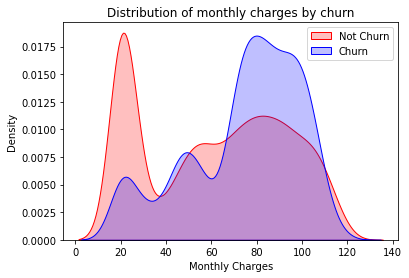

In [49]:
# VISUALIZE CONTINUOUS FEATURES WITH TARGET

# MONTHLY CHARGES
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')


<font size = 3>ii) Churn by Total Charges: It seems that there is higer churn when the total charges are lower.</font>



Text(0.5, 1.0, 'Distribution of total charges by churn')

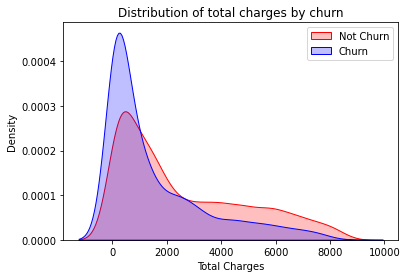

In [50]:
# TOTAL CHARGES
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')


<font size = 3>iii) Churn vs Tenure: As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.
</font>

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

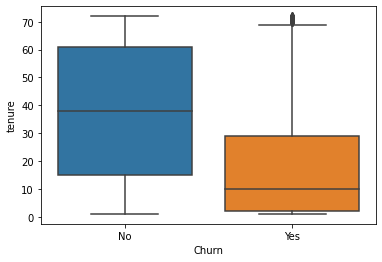

In [51]:
sns.boxplot(x = telecom_cust.Churn, y = telecom_cust.tenure)


# Data pre-processing 

### drop nan, duplicates, encode binary features, one-hot encoding

In [52]:
# convert total sum to numeric feature (DONE ABOVE)
#telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')
#telecom_cust.isnull().sum()


In [53]:
#Removing missing values (DONE ABOVE)
#telecom_cust.dropna(inplace = True)


In [54]:
# number of unique values in dataframe
telecom_cust.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

### Encoding categorical features:

In [55]:
#Remove customer IDs from the data set
#and encode target feature
df2 = telecom_cust.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)


In [56]:
#encode binary features to 0,1
df2['gender'].replace(['Male','Female'],[1,0], inplace=True)
df2['Partner'].replace(['Yes','No'],[1,0], inplace=True)
df2['Dependents'].replace(['Yes','No'],[1,0], inplace=True)
df2['PhoneService'].replace(['Yes','No'],[1,0], inplace=True)
df2['PaperlessBilling'].replace(['Yes','No'],[1,0], inplace=True)


     

In [57]:
# count and drop duplicates
print(df2.duplicated().sum())
df2.drop_duplicates(inplace=True)

22


### One-hot encoding for features with more than 2 categories 

In [58]:
#Let's convert all the categorical variables into dummy variables (on-hot encoding)
df_dummies = pd.get_dummies(df2)


In [59]:
# number of unique values in dataframe
df_dummies.nunique()
#df_dummies.head()
print()

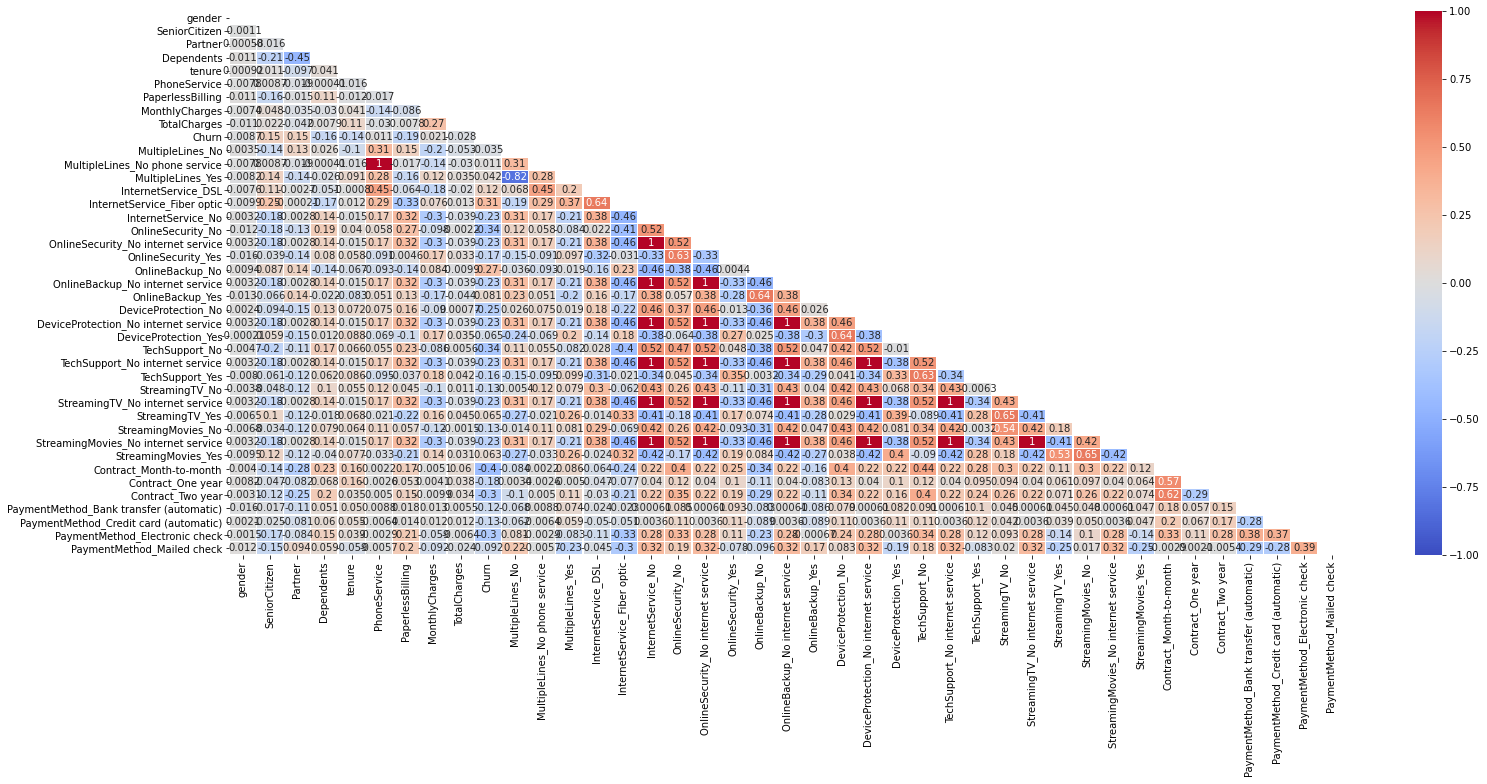

In [60]:
plt.figure(figsize=(25, 10))

corr = df_dummies.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [61]:
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])


# Machine Learning Model Evaluations and Predictions

In [62]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


In [63]:
# scale train data from 0 -> 1
from sklearn.preprocessing import MinMaxScaler
features = X_train.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_train_scaled.columns = features

#scale test data
features2 = X_test.columns.values
scaler2 = MinMaxScaler(feature_range = (0,1))
scaler2.fit(X_test)
X_test_scaled = pd.DataFrame(scaler2.transform(X_test))
X_test_scaled.columns = features2


### KNN

In [64]:
#KNN model
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors = 11) 
model_knn.fit(X_train,y_train)
predicted_y = model_knn.predict(X_test)

prediction_test = model_knn.predict(X_test)

print (metrics.accuracy_score(y_test, prediction_test))


0.7960057061340942


### Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier


model_DecTree = DecisionTreeClassifier()
model_DecTree.fit(X_train, y_train)
predictdt_y = model_DecTree.predict(X_test)
print("decision tree Classifier accuracy")
metrics.accuracy_score(y_test, predictdt_y)


decision tree Classifier accuracy


0.7318116975748931

### SVM

In [66]:
from sklearn.svm import SVC


model_svc = SVC(random_state = 1)
model_svc.fit(X_train_scaled,y_train)
predict_y = model_svc.predict(X_test)

prediction_test = model_svc.predict(X_test_scaled)

print (metrics.accuracy_score(y_test, prediction_test))


0.8138373751783167


### Logistic regression

In [85]:
# logistic regression model

from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

prediction_test = model_lr.predict(X_test_scaled)


In [80]:
evaluation_metrics(y_test, prediction_test)

accuracy: 0.8302425106990015
precision: 0.7079037800687286
recall: 0.5738161559888579
f1_score 0.633846153846154
specificity: 0.9185043144774688


Best Threshold=0.257144, G-Mean=0.772
0.8133704735376045


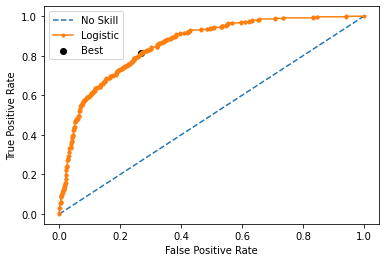

In [68]:
draw_roc(model_lr, X_test_scaled, y_test)



In [69]:
y_pred_lr = pred_with_threshold(model_lr, X_test_scaled, y_test)
evaluation_metrics(y_test, y_pred_lr)

accuracy: 0.753922967189729
precision: 0.512280701754386
recall: 0.8133704735376045
f1_score 0.6286329386437031
specificity: 0.7334611697027804


### Random Forest

In [86]:
#  random forest model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)



In [82]:
evaluation_metrics(y_test, prediction_test)

accuracy: 0.8288159771754636
precision: 0.7448559670781894
recall: 0.5041782729805014
f1_score 0.6013289036544851
specificity: 0.9405560882070949


Best Threshold=0.397716, G-Mean=0.773
0.6908077994428969


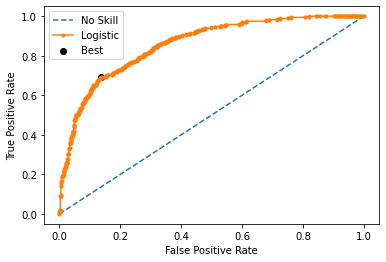

In [71]:
draw_roc(model_rf, X_test, y_test)



In [72]:
y_pred_rf = pred_with_threshold(model_rf, X_test, y_test)
evaluation_metrics(y_test, y_pred_rf)

accuracy: 0.8202567760342369
precision: 0.6375321336760925
recall: 0.6908077994428969
f1_score 0.6631016042780749
specificity: 0.8648130393096836


### AdaBoost

In [87]:
# adaboost model
from sklearn.ensemble import AdaBoostClassifier

model_adaB = AdaBoostClassifier()
model_adaB.fit(X_train, y_train)
prediction_test = model_adaB.predict(X_test)
print("AdaBoost Classifier accuracy")


AdaBoost Classifier accuracy


In [84]:
evaluation_metrics(y_test, prediction_test)

accuracy: 0.833095577746077
precision: 0.7289377289377289
recall: 0.5543175487465181
f1_score 0.6297468354430379
specificity: 0.9290508149568553


Best Threshold=0.494829, G-Mean=0.778
0.8272980501392758


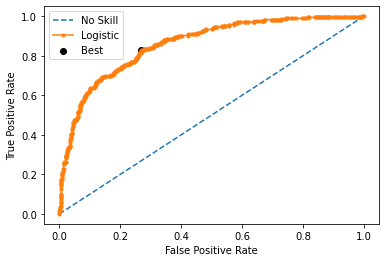

In [74]:
draw_roc(model_adaB, X_test, y_test)



In [75]:
y_pred_adaB = pred_with_threshold(model_adaB, X_test, y_test)
evaluation_metrics(y_test, y_pred_adaB)

accuracy: 0.7560627674750356
precision: 0.5147313691507799
recall: 0.8272980501392758
f1_score 0.6346153846153846
specificity: 0.7315436241610739


# My Custom functions

In [76]:
# function for ROC curve

from numpy import argmax
from numpy import sqrt

def draw_roc(model, xtest, ytest):
    probs = model.predict_proba(xtest)

    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    
    # calculate the g-mean for each threshold

    gmeans = sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean

    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    print(tpr[ix])
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    #return y_pred

In [77]:
# function for confusion matrix and metrics.
def pred_with_threshold(model, xtest, ytest):
    probs = model.predict_proba(xtest)

    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean
    ix = argmax(gmeans)

    y_pred = (probs >= thresholds[ix]).astype(int)
    
    return y_pred

    

In [78]:
# function for evaluation metrics
def evaluation_metrics(ytest, ypred):
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    print ('accuracy:',metrics.accuracy_score(ytest, ypred))
    print('precision:',precision_score(ytest, ypred))
    print('recall:',recall_score(ytest, ypred))
    print('f1_score',f1_score(ytest, ypred))
    print('specificity:',tn/(tn+fp))


In [40]:
def bar_with_churn_label(df,col):
    colors = ['#cd5c5c','#2e8b57']
    contract_churn = df.groupby([col,'Churn']).size().unstack()

    ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = False,
                                                                rot = 0, 
                                                                figsize = (22,13),
                                                                color = colors)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc='best',prop={'size':14},title = 'Churn')
    ax.set_ylabel('% Customers',size = 14)
    title = 'Churn by ' + col
    ax.set_title(title,size = 14)

    # Code to add the data labels on the stacked bar chart
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                    color = 'white',
                   weight = 'bold',
                   size = 14)


In [41]:
def draw_hist(df,colname):
    colors = ['#cd5c5c','#2e8b57']
    ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar',
                                                                           stacked = False,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel('% Customers',size = 14)
    ax.set_xlabel('Churn',size = 14)
    ax.set_title('Churn Rate', size = 14)

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_x()+.15, i.get_height()-4.0, \
                str(round((i.get_height()/total), 1))+'%',
                fontsize=12,
                color='white',
               weight = 'bold',
               size = 14)
